In [2]:
import pandas as pd
from datetime import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt


In [8]:
url = 'https://raw.githubusercontent.com/sujansth/Ecommerce-demand-prediction/master/data/best%20selling%20site%231%20-%2011teamsports.cz.csv'

df = pd.read_csv(url)

In [9]:
df

,date,total_revenue
0,2019-06-01,1743.319764
1,2019-06-03,554.969767
2,2019-06-04,12318.476325
3,2019-06-05,24104.458469
4,2019-06-06,5252.234095
...,...,...
949,2022-01-10,10959.742608
950,2022-01-11,10468.838735
951,2022-01-12,9520.911211
952,2022-01-13,9926.975944


In [10]:
df = df.rename(columns={'date':'ds', 'total_revenue':'y'})

In [11]:
df['ds'] = pd.to_datetime(df['ds'])

In [12]:
df.shape

(954, 2)

In [13]:
df

,ds,y
0,2019-06-01,1743.319764
1,2019-06-03,554.969767
2,2019-06-04,12318.476325
3,2019-06-05,24104.458469
4,2019-06-06,5252.234095
...,...,...
949,2022-01-10,10959.742608
950,2022-01-11,10468.838735
951,2022-01-12,9520.911211
952,2022-01-13,9926.975944


In [17]:
train_df = df[:862]

test_df = df[862:]

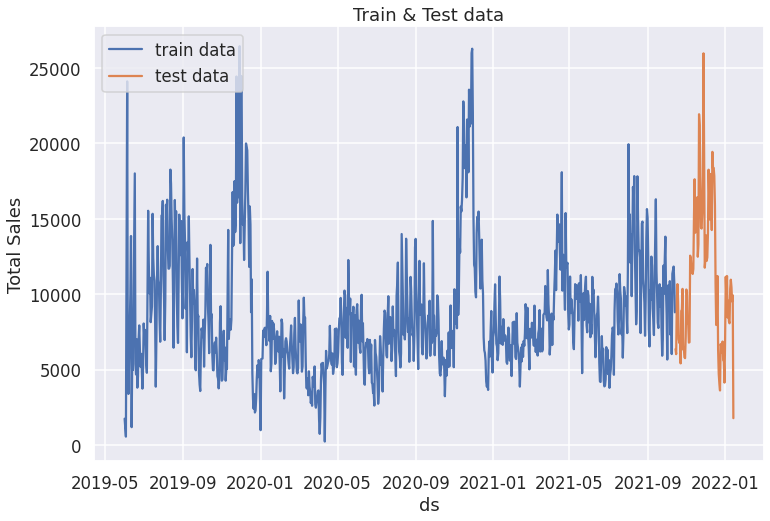

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
sns.lineplot(x='ds', y='y', data=train_df, label='train data')
sns.lineplot(x='ds', y='y', data=test_df, label='test data')

ax.legend(loc='upper left')
ax.set(title="Train & Test data", ylabel='Total Sales')
plt.show()

In [19]:
# Trainin the model

model = Prophet(seasonality_mode='additive')
model.add_seasonality(name='monthly', period=30, fourier_order=10)
model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = model.make_future_dataframe(periods=90, freq='d', include_history=False)
forecast = model.predict(future)
forecast[['ds','yhat']]

,ds,yhat
0,2021-10-15,7571.561774
1,2021-10-16,6573.244077
2,2021-10-17,8744.580007
3,2021-10-18,10388.362876
4,2021-10-19,9234.823765
...,...,...
85,2022-01-08,7931.001645
86,2022-01-09,10639.403861
87,2022-01-10,11920.423171
88,2022-01-11,10879.301653


In [21]:
!pip install prophet


     |████████████████████████████████| 65 kB 2.6 MB/s 
     |████████████████████████████████| 49 kB 5.1 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6640643 sha256=0dc152eb0fc0268a74cc23642d6d2d2642392010a7d8a492ec2dcee53285ba8f
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


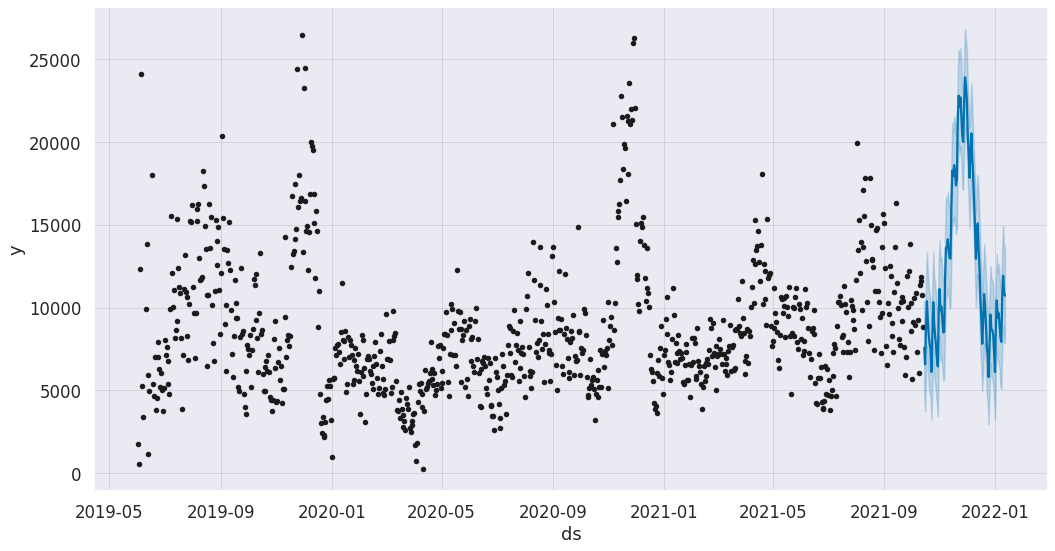

In [22]:
# ploting the forecast

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)

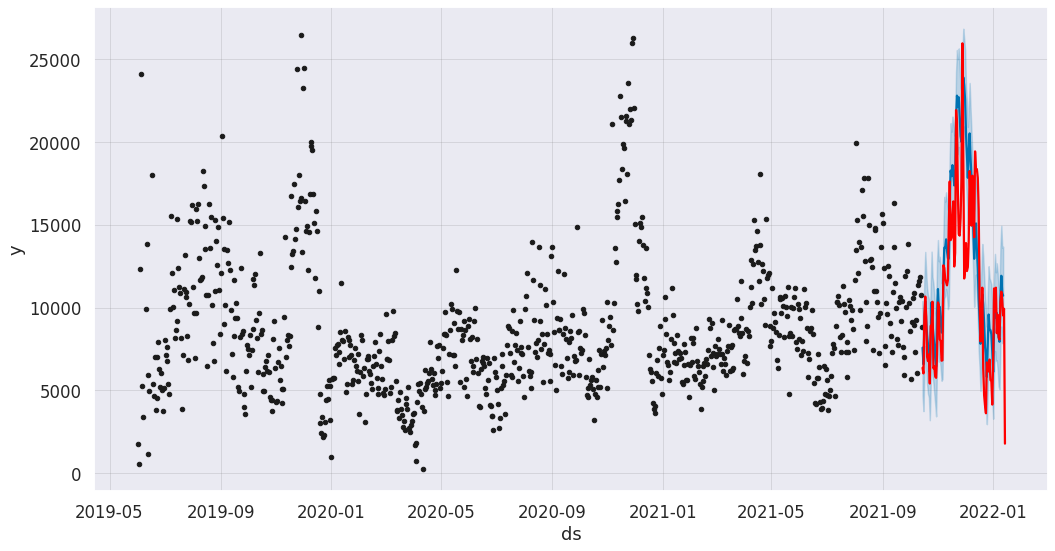

In [23]:
# comparing Forecast vs Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='red')


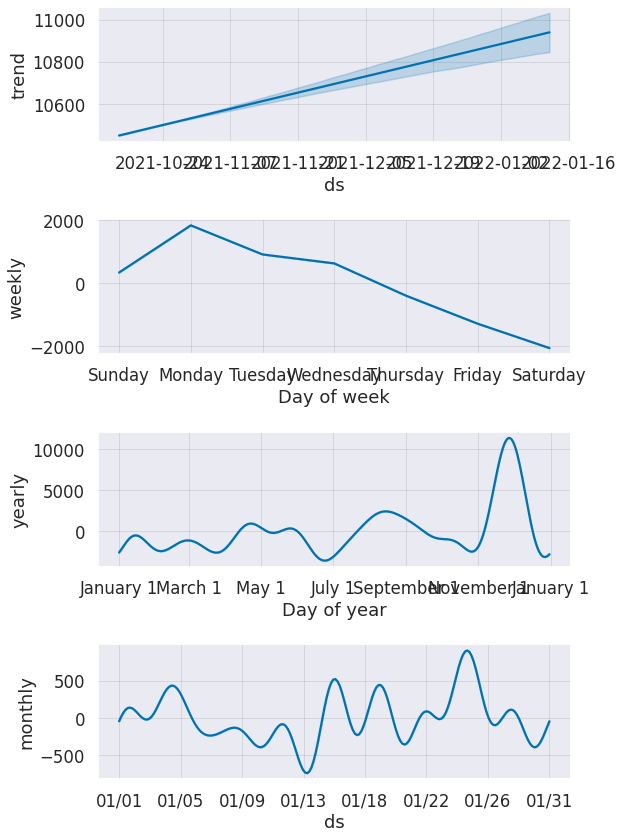

In [25]:
# plotting model components

model.plot_components(forecast);

In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

error = sqrt(mean_squared_error(test_df.y[:-2], forecast.yhat))
print('Test RMSE: %.3f' % error)

Test RMSE: 3363.333


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


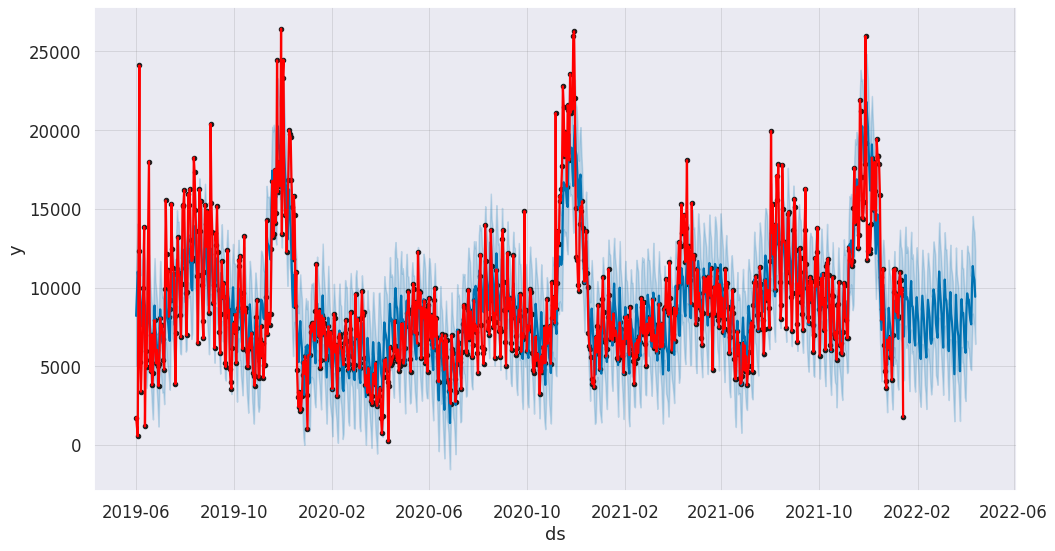

In [27]:
# Now fitting the whole data set

model = Prophet(seasonality_mode='additive')
model.add_seasonality(name='monthly', period=30, fourier_order=10)
model.fit(df)


future = model.make_future_dataframe(periods=90, freq='d', include_history=True)
forecast = model.predict(future)
forecast[['ds','yhat']]



# comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
ax.plot(df.ds, df.y, color='red')


In [28]:
three_months_prediction = pd.DataFrame(forecast[['ds','yhat']][-90:])
three_months_prediction.head()

,ds,yhat
954,2022-01-15,6883.580677
955,2022-01-16,9717.683522
956,2022-01-17,10805.064038
957,2022-01-18,9256.497221
958,2022-01-19,9373.203454


In [29]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='90 days', initial='90', period='90 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

INFO:fbprophet:Making 10 forecasts with cutoffs between 2019-07-29 00:00:00 and 2021-10-16 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

MAPE:  196.66262564612614


In [30]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-07-30,10032.013014,7047.979992,12898.084874,15198.848807,2019-07-29
1,2019-07-31,9895.811356,6467.782187,12994.723808,16181.549967,2019-07-29
2,2019-08-01,3159.480983,116.668063,6099.071395,11238.399589,2019-07-29
3,2019-08-02,-8426.169605,-11480.041527,-5359.916188,9658.931763,2019-07-29
4,2019-08-03,-7062.568226,-10045.414451,-4091.838159,6956.255413,2019-07-29


In [31]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,9 days,1.013003e+08,10064.803514,4253.367067,0.450422,0.235475,0.666667
1,10 days,1.669772e+08,12921.964967,5101.451706,0.513893,0.246771,0.666667
2,11 days,2.706689e+08,16452.017115,6153.334986,0.606161,0.268411,0.688889
3,12 days,4.130654e+08,20324.010715,7233.644641,0.691837,0.246317,0.722222
4,13 days,6.170566e+08,24840.622985,8597.662151,0.811426,0.252063,0.711111
...,...,...,...,...,...,...,...
77,86 days,1.261082e+09,35511.712213,14059.230915,2.173353,0.388236,0.466667
78,87 days,1.177152e+09,34309.649797,13465.141605,2.101374,0.388236,0.466667
79,88 days,1.051572e+09,32427.951189,12628.696332,2.048567,0.387045,0.466667
80,89 days,8.937725e+08,29896.028827,11431.141303,1.866631,0.384035,0.477778


Text(0.5, 1.0, ' Forecast Vs Actual')

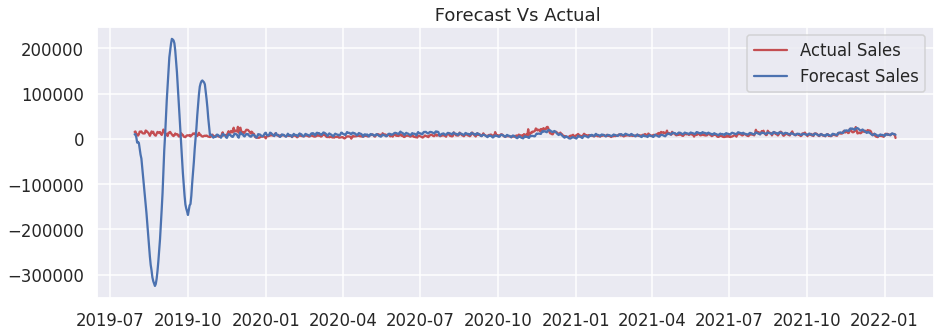

In [32]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

In [33]:
# Hyperparameter tuning

from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [ ]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1f09bd4850>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1f105a7f50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1f0d054090>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f1f0c3bc8d0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in par

In [35]:
tuning_results.sort_values('rmse')

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
14,multiplicative,0.001,0.10,15,2895.922617
201,additive,0.010,0.01,6,3044.979255
200,additive,0.010,0.01,3,3166.477136
205,additive,0.010,0.01,18,3196.435348
174,additive,0.001,0.10,15,3203.112960
...,...,...,...,...,...
316,additive,0.500,10.00,21,50926.526653
311,additive,0.500,10.00,6,51808.916264
26,multiplicative,0.001,1.00,21,52080.263931
315,additive,0.500,10.00,18,53272.283724


In [36]:
final_model = Prophet(growth='linear', seasonality_mode='multiplicative', changepoint_prior_scale=0.001, seasonality_prior_scale=0.10, n_changepoints=15)
final_model.add_seasonality(name='monthly', period=30, fourier_order=10)
final_model.fit(train_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [37]:
future = final_model.make_future_dataframe(periods=90, freq='d', include_history=False)
final_forecast = final_model.predict(future)
final_forecast[['ds','yhat']]

,ds,yhat
0,2021-10-15,6190.310144
1,2021-10-16,5230.618005
2,2021-10-17,7406.457867
3,2021-10-18,9070.265129
4,2021-10-19,8061.376072
...,...,...
85,2022-01-08,6082.640179
86,2022-01-09,8796.102099
87,2022-01-10,10012.906484
88,2022-01-11,8858.240486


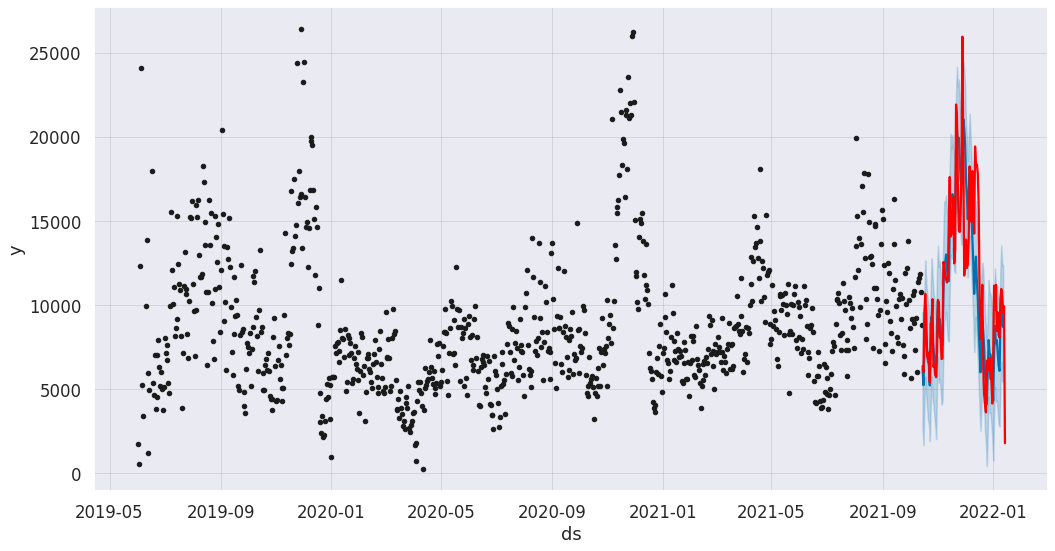

In [40]:
# comparing Forecast (based on 30 days after train data) vs  actual test_data

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig = final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='red')

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

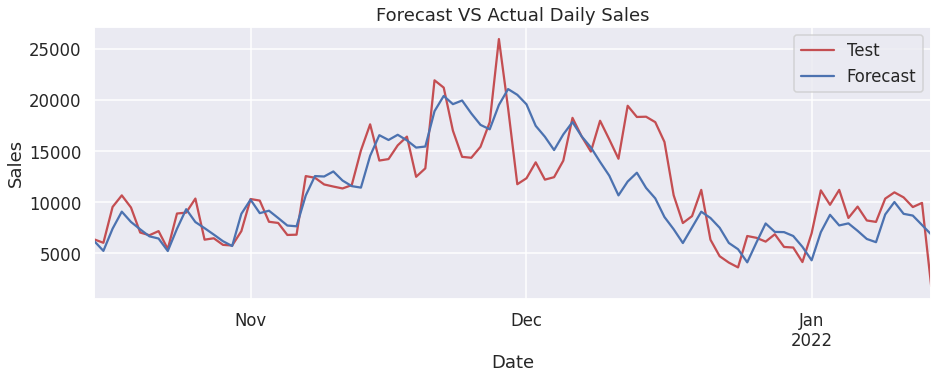

In [41]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [42]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  22.232341997312925
